# Sequence to Sequence Classification by RNN

- Creating the **data pipeline** with `tf.data`
- Preprocessing word sequences (variable input sequence length) using `padding technique` by `user function (pad_seq)`
- Using `tf.nn.embedding_lookup` for getting vector of tokens (eg. word, character)
- Training **many to many classification** with `tf.contrib.seq2seq.sequence_loss`
- Masking unvalid token with `tf.sequence_mask`
- Creating the model as **Class**

In [1]:
import os
import sys
import time
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

slim = tf.contrib.slim
rnn = tf.contrib.rnn

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Prepare example data 

In [2]:
sentences = [['I', 'feel', 'hungry'],
             ['You', 'are', 'a', 'genius'],
             ['tensorflow', 'is', 'very', 'difficult'],
             ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
             ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
       ['pronoun', 'verb', 'preposition', 'noun'],
       ['noun', 'verb', 'adverb', 'adjective'],
       ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
       ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [3]:
# word dictionary
bag_of_words = []
for sentence in sentences:
  bag_of_words += sentence
bag_of_words = list(set(bag_of_words))
bag_of_words.sort()
bag_of_words = ['<pad>'] + bag_of_words

word2idx = {word : idx for idx, word in enumerate(bag_of_words)} # word to index
idx2word = [word for word in bag_of_words] # index to word

{'<pad>': 0,
 'I': 1,
 'a': 2,
 'changing': 3,
 'deep': 4,
 'difficult': 5,
 'fast': 6,
 'feel': 7,
 'for': 8,
 'framework': 9,
 'hungry': 10,
 'is': 11,
 'learning': 12,
 'tensorflow': 13,
 'very': 14}

In [4]:
#print("word2idx: {}".format(word2idx))
word2idx

['<pad>',
 'I',
 'a',
 'changing',
 'deep',
 'difficult',
 'fast',
 'feel',
 'for',
 'framework',
 'hungry',
 'is',
 'learning',
 'tensorflow',
 'very']

In [ ]:
#print("idx2word: {}".format(idx2word))
idx2word

In [5]:
# pos dictionary
bag_of_pos = []
for item in pos:
  bag_of_pos += item
bag_of_pos = list(set(bag_of_pos))
bag_of_pos.sort()
bag_of_pos = ['<pad>'] + bag_of_pos
print("bag_of_pos: {}".format(bag_of_pos))

pos2idx = {pos : idx for idx, pos in enumerate(bag_of_pos)} # pos to index
idx2pos = [pos for pos in bag_of_pos] # index to pos

bag_of_pos: ['<pad>', 'adjective', 'adverb', 'determiner', 'noun', 'preposition', 'pronoun', 'verb']


{'<pad>': 0,
 'adjective': 1,
 'adverb': 2,
 'determiner': 3,
 'noun': 4,
 'preposition': 5,
 'pronoun': 6,
 'verb': 7}

In [6]:
#print("pos2idx: {}".format(pos2idx))
pos2idx

['<pad>',
 'adjective',
 'adverb',
 'determiner',
 'noun',
 'preposition',
 'pronoun',
 'verb']

In [ ]:
#print("idx2pos: {}".format(idx2pos))
idx2pos

### Create pad_seq function

In [7]:
def pad_seq(sequences, max_length, dic):
  """Padding sequences
  Padding a special charcter '<pad>' from the end of sentence to max_length
  
  Args:
    sequences (list of characters): input data
    max_length (int): max length for padding
    dic (dictionary): char to index
  
  Returns:
    seq_indices (2-rank np.array): 
    seq_length (1-rank np.array): sequence lengthes of all data
  """
  seq_length, seq_indices = [], []
  for sequence in sequences:
    seq_length.append(len(sequence))
    seq_idx = [dic.get(char) for char in sequence]
    seq_idx += (max_length - len(seq_idx)) * [dic.get('<pad>')] # 0 is idx of meaningless token "<pad>"
    seq_indices.append(seq_idx)
  return np.array(seq_indices), np.array(seq_length)

### Pre-process data

In [8]:
max_length = 10
X_indices, X_length = pad_seq(sequences=sentences, max_length=max_length, dic=word2idx)

In [9]:
print("X_indices")
print(X_indices)
print("X_length")
print(X_length)

X_indices
[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]
X_length
[3 4 7 5]


In [10]:
y_string = np.array([item + ['<pad>'] * (max_length - len(item)) for item in pos])
print(y_string)

[['pronoun' 'verb' 'adjective' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>'
  '<pad>' '<pad>']
 ['noun' 'verb' 'adverb' 'adjective' '<pad>' '<pad>' '<pad>' '<pad>'
  '<pad>' '<pad>']
 ['noun' 'verb' 'determiner' 'noun' 'preposition' 'adjective' 'noun'
  '<pad>' '<pad>' '<pad>']
 ['noun' 'verb' 'adverb' 'adjective' 'verb' '<pad>' '<pad>' '<pad>'
  '<pad>' '<pad>']]


In [11]:
y = np.array([list(map(lambda el : pos2idx.get(el), item)) for item in y_string])
print(y)

[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


### Define SimPosRNN

In [12]:
class PosRNN:
  def __init__(self, seq_indices, seq_length, labels, num_classes, hidden_dim, max_length, word2idx):
    # Data pipeline
    with tf.variable_scope('input_layer'):
      self._seq_indices = seq_indices
      self._seq_length = seq_length
      self._labels = labels

      one_hot = tf.eye(len(word2idx), dtype = tf.float32)
      self._one_hot = tf.get_variable(name='one_hot_embedding',
                                      initializer=one_hot,
                                      trainable=False) # embedding vector training 안할 것이기 때문
      self._seq_embeddings = tf.nn.embedding_lookup(params=self._one_hot,
                                                    ids=self._seq_indices)

    # LSTM cell (many to many)
    with tf.variable_scope('lstm_cell'):
      cell = rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)
      score_cell = rnn.OutputProjectionWrapper(cell=cell,
                                               output_size=num_classes)
      self._outputs, _ = tf.nn.dynamic_rnn(cell=score_cell, inputs=self._seq_embeddings,
                                           sequence_length=self._seq_length,
                                           dtype=tf.float32)

    with tf.variable_scope('seq2seq_loss'):
      masks = tf.sequence_mask(lengths=self._seq_length, maxlen=max_length, dtype=tf.float32)
      self.seq2seq_loss = tf.contrib.seq2seq.sequence_loss(logits=self._outputs,
                                                           targets=self._labels,
                                                           weights=masks)

    with tf.variable_scope('prediction'):
      self._prediction = tf.argmax(input=self._outputs,
                                   axis=2, output_type=tf.int32)

  def predict(self, sess, seq_indices, seq_length):
    feed_dict = {self._seq_indices : seq_indices, self._seq_length : seq_length}
    return sess.run(self._prediction, feed_dict=feed_dict)

### Create a model of SimPosRNN

In [13]:
# hyper-parameters
num_classes = len(idx2pos)
learning_rate = .003
batch_size = 2
max_epochs = 100

### Set up dataset with `tf.data`

#### create input pipeline with `tf.data.Dataset`

In [14]:
## create data pipeline with tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((X_indices, X_length, y))
train_dataset = train_dataset.shuffle(buffer_size = 100)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

<BatchDataset shapes: ((?, 10), (?,), (?, 10)), types: (tf.int64, tf.int64, tf.int64)>


#### Define Iterator

In [15]:
train_iterator = train_dataset.make_initializable_iterator()
seq_indices, seq_length, labels = train_iterator.get_next()

In [16]:
pos_rnn = PosRNN(seq_indices=seq_indices, seq_length=seq_length,
                 labels=labels, num_classes=num_classes,
                 hidden_dim=16, max_length=max_length,
                 word2idx=word2idx)

### Creat training op and train model

In [17]:
## create training op
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(pos_rnn.seq2seq_loss)

### `tf.Session()` and train

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_history = []
step = 0
for epochs in range(max_epochs):
  start_time = time.time()
  sess.run(train_iterator.initializer)
  
  avg_loss = []
  while True:
    try:
      _, loss_ = sess.run([train_op, pos_rnn.seq2seq_loss])
      avg_loss.append(loss_)
      step += 1

    except tf.errors.OutOfRangeError:
      #print("End of dataset")  # ==> "End of dataset"
      break

  avg_loss_ = np.mean(avg_loss)
  loss_history.append(avg_loss_)
  
  duration = time.time() - start_time
  examples_per_sec = batch_size / float(duration)
  print("epochs: {}, step: {}, loss: {:g}, ({:.2f} examples/sec; {:.3f} sec/batch)".format(epochs+1, step, avg_loss_, examples_per_sec, duration))

epochs: 1, step: 2, loss: 2.07756, (6.57 examples/sec; 0.304 sec/batch)
epochs: 2, step: 4, loss: 2.06506, (252.65 examples/sec; 0.008 sec/batch)
epochs: 3, step: 6, loss: 2.04792, (235.43 examples/sec; 0.008 sec/batch)
epochs: 4, step: 8, loss: 2.0337, (243.67 examples/sec; 0.008 sec/batch)
epochs: 5, step: 10, loss: 2.01939, (244.70 examples/sec; 0.008 sec/batch)
epochs: 6, step: 12, loss: 2.00484, (242.00 examples/sec; 0.008 sec/batch)
epochs: 7, step: 14, loss: 1.99397, (255.17 examples/sec; 0.008 sec/batch)
epochs: 8, step: 16, loss: 1.97889, (248.82 examples/sec; 0.008 sec/batch)
epochs: 9, step: 18, loss: 1.96329, (241.58 examples/sec; 0.008 sec/batch)
epochs: 10, step: 20, loss: 1.94182, (246.46 examples/sec; 0.008 sec/batch)
epochs: 11, step: 22, loss: 1.9256, (239.98 examples/sec; 0.008 sec/batch)
epochs: 12, step: 24, loss: 1.90761, (252.24 examples/sec; 0.008 sec/batch)
epochs: 13, step: 26, loss: 1.88803, (225.93 examples/sec; 0.009 sec/batch)
epochs: 14, step: 28, loss: 1

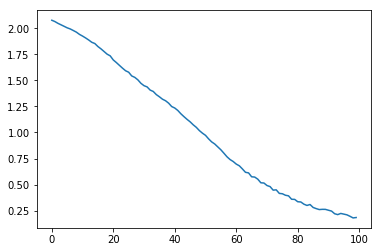

In [19]:
plt.plot(loss_history, label='train')

In [20]:
y_pred = pos_rnn.predict(sess=sess, seq_indices=X_indices, seq_length=X_length)
print(y_pred)

[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [21]:
result_str = []
for example in y_pred:
  result_str.append([idx2pos[idx] for idx in example])
  
for examples in zip(y_string, result_str):
  print("        Label: ", ' '.join(examples[0]))
  print("Prediction: ", ' '.join(examples[1]))

        Label:  pronoun verb adjective <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction:  pronoun verb adjective <pad> <pad> <pad> <pad> <pad> <pad> <pad>
        Label:  noun verb adverb adjective <pad> <pad> <pad> <pad> <pad> <pad>
Prediction:  noun verb adverb adjective <pad> <pad> <pad> <pad> <pad> <pad>
        Label:  noun verb determiner noun preposition adjective noun <pad> <pad> <pad>
Prediction:  noun verb determiner noun preposition adjective noun <pad> <pad> <pad>
        Label:  noun verb adverb adjective verb <pad> <pad> <pad> <pad> <pad>
Prediction:  noun verb adverb adjective verb <pad> <pad> <pad> <pad> <pad>
